# Baseline LSTM Model

This is the first of three LSTM models we will build. This is the 'baseline,' meaning it will not consider Twitter features. Our hope is those features will be able to improve performance fo the final model.

### Setup

In [12]:
import datetime as dt
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.regularizers import L1L2

plt.style.use('ggplot')

#### Define helper functions

In [2]:
# Function to replace every NULL column with the mean from the training set (Naive Bayes)
def replace_nans_mean(df, split_date):
    split_idx = np.max(df.loc[df['date']<split_date].index.values)
    df_cp = df.copy()
    for col in df_cp.columns:
        if col == 'date':
            continue
        naive_estimate = df_cp.loc[:split_idx, col].mean()
        df_cp.loc[pd.isnull(df_cp[col]), col] = naive_estimate
        
    return df_cp

# Function to build 3-dimensional ndarray for LSTM based on input df and lookback window
def build_lstm_data(df, window):
    X = []
    y = []
    for i in range(len(df)-window+1):
        temp_set = df[i:(i+window)].copy()
        X.append(temp_set[:,1:])
        y.append(temp_set[window-1,0])

    return np.array(X), np.array(y)

In [3]:
# Select features for RNN, along with target. Specifically, remove averages.
features = [
    'target',
    'date',
    'player_played',
    'player_home',
    'betting_over_under_line',
    'betting_spread',
    'weather_temperature',
    'weather_wind_mph',
    'weather_humidity',
    'weather_inclement',
    'defense_fumbles_forced_moving_avg_1',
    'defense_fumbles_forced_moving_avg_3',
    'defense_fumbles_forced_moving_avg_5',
    'defense_interceptions_moving_avg_1',
    'defense_interceptions_moving_avg_3',
    'defense_interceptions_moving_avg_5',
    'defense_pass_yards_allowed_moving_avg_1',
    'defense_pass_yards_allowed_moving_avg_3',
    'defense_pass_yards_allowed_moving_avg_5',
    'defense_rush_yards_allowed_moving_avg_1',
    'defense_rush_yards_allowed_moving_avg_3',
    'defense_rush_yards_allowed_moving_avg_5',
    'defense_sacks_moving_avg_1',
    'defense_sacks_moving_avg_3',
    'defense_sacks_moving_avg_5',
    'defense_points_allowed_moving_avg_1',
    'defense_points_allowed_moving_avg_3',
    'defense_points_allowed_moving_avg_5',
]

# Define data on which to split train and test sets
split_date = pd.Timestamp(2012,5,1)

### Tom Brady

In [4]:
# Read in data
brady = pd.read_csv('../data/data_final/final/features_raw/brady.csv')

brady = brady.loc[:, features]
brady['date'] = pd.to_datetime(brady['date'])

In [5]:
# Data cleaning
brady = replace_nans_mean(brady, split_date)

In [6]:
# Train + test set indices
train_idx = brady.loc[brady['date']<split_date].index.values
test_idx = brady.loc[brady['date']>split_date].index.values

# Scale Features
brady.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(brady)
brady = scaler.transform(brady)

# Split into training and test set with window size 1 for reference
train, test = brady[train_idx], brady[test_idx]

In [7]:
# Create train and test sets
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx)[:-window+1]], y[(train_idx)[:-window+1]]
X_test, y_test = X[(test_idx-window+1)[0]:], y[(test_idx-window+1)[0]:]

In [8]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [9]:
%%time
# Build networks. Loop n times to get a handle on randomness caused by random initialization of the weights.
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, bias_regularizer=L1L2(0.01,0.01)))
    model.add(Dropout(.3))
    model.add(LSTM(30))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=250, batch_size=5, validation_data = (X_test, y_test), verbose=0, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
    

CPU times: user 11min, sys: 2min 16s, total: 13min 16s
Wall time: 6min 28s


In [15]:
# Save MAEs for statistical analysis
with open('../data/prediction_outputs/brady_baseline_lstm_maes', 'wb+') as f:
    pickle.dump(maes, f)
# Save results of best model
with open('../data/prediction_outputs/brady_best_baseline_lstm_preds', 'wb+') as f:
    pickle.dump(best_preds, f)

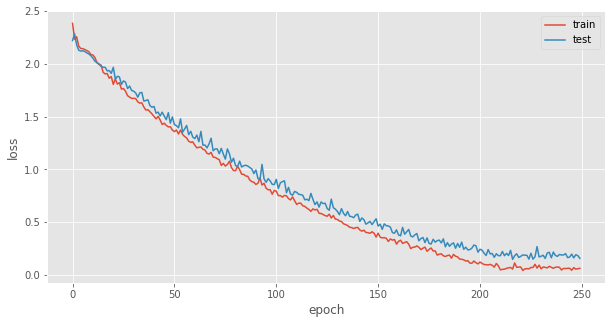

In [17]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [18]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 4.97
Best MAE: 3.85
Average RMSE: 5.65
Average MAE: 4.43


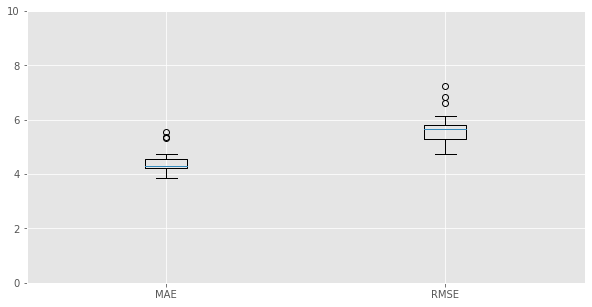

In [19]:
# Boxplot of MAEs and RMSEs for each trial.
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim(0,10)
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual')

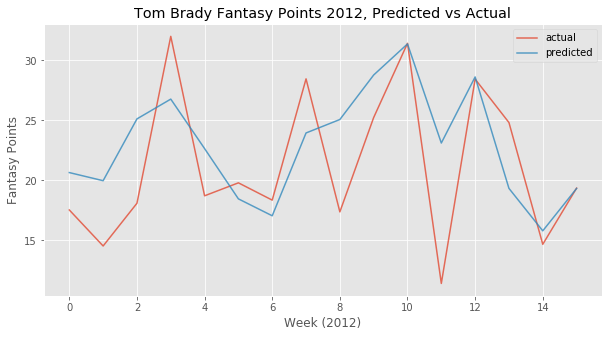

In [20]:
# Plot predictions versus actuals
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual')

##### Online Training

In [43]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(100, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), return_sequences=True, bias_regularizer=L1L2(0.01,0.01), stateful=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    n_iters = 250
    for k in range(n_iters):
#         t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
#         print('Epoch {}/{}'.format(k+1, n_iters))
#         print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
             

CPU times: user 56min 59s, sys: 9min 45s, total: 1h 6min 44s
Wall time: 32min 18s


In [44]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 5.37
Best MAE: 4.11
Average RMSE: 5.83
Average MAE: 4.51


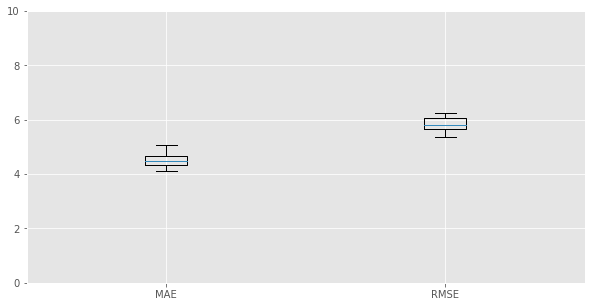

In [45]:
# Boxplot
plt.rcParams['figure.figsize'] = (10, 5)
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

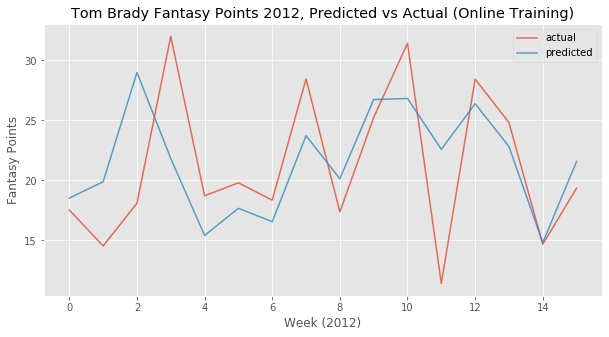

In [46]:
# Predicted vs actual
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

### LeSean McCoy

In [21]:
# Read in data
mccoy = pd.read_csv('../data/data_final/final/features_raw/mccoy.csv')
mccoy = mccoy.loc[:, features]
mccoy['date'] = pd.to_datetime(mccoy['date'])
mccoy = replace_nans_mean(mccoy, split_date)

In [22]:
# Train + test set indices
mccoy_played_only = mccoy.loc[mccoy['player_played']==1].copy().reset_index(drop=True)
train_idx = mccoy_played_only.loc[mccoy['date']<split_date].index.values
test_idx = mccoy_played_only.loc[mccoy_played_only['date']>split_date].index.values

# Scale Features
mccoy.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(mccoy)
mccoy = scaler.transform(mccoy)

# Split into training and test set with window size 1 for reference
train, test = mccoy[train_idx], mccoy[test_idx]

In [23]:
# Create train and test sets
window = 2

X, y = build_lstm_data(mccoy, window)
X = X[y!=0] # Keep games not played for time series, but do not make predictions
y = y[y!=0]

X_train, y_train = X[(train_idx)[:-window+1]], y[(train_idx)[:-window+1]]
X_test, y_test = X[(test_idx-window+1)[0]:], y[(test_idx-window+1)[0]:]

In [24]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [25]:
%%time
# Build networks. Loop n times.
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(20))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=20, batch_size=3, validation_data = (X_test, y_test), verbose=0, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv


CPU times: user 6min 47s, sys: 41.4 s, total: 7min 28s
Wall time: 7min


In [26]:
# Save MAEs for statistical analysis
with open('../data/prediction_outputs/mccoy_baseline_lstm_maes', 'wb+') as f:
    pickle.dump(maes, f)
# Save results of best model
with open('../data/prediction_outputs/mccoy_best_baseline_lstm_preds', 'wb+') as f:
    pickle.dump(best_preds, f)

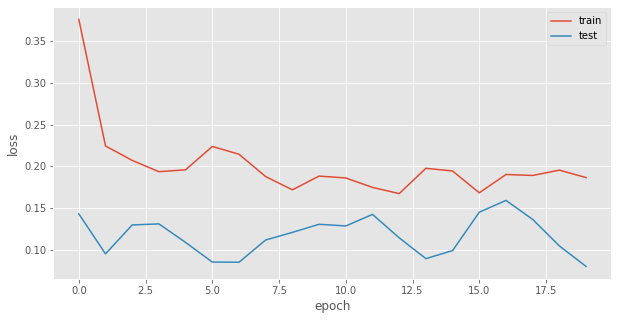

In [27]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [28]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 3.08
Best MAE: 2.55
Average RMSE: 4.18
Average MAE: 3.62


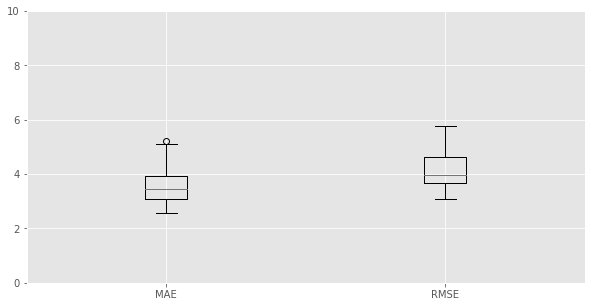

In [29]:
# Boxplots 
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

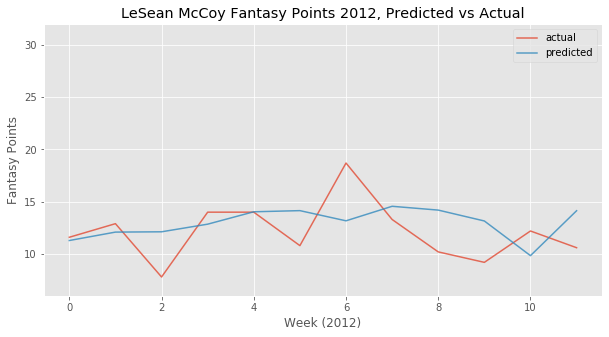

In [31]:
# Predicted vs actual
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.ylim((6, 32))
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

#### Online Training

In [8]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(20))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    n_iters = 20
    for k in range(n_iters):
#         t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
#         print('Epoch {}/{}'.format(k+1, n_iters))
#         print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
             

CPU times: user 11min 24s, sys: 1min 47s, total: 13min 11s
Wall time: 7min 11s


In [9]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 5.16
Best MAE: 4.37
Average RMSE: 6.65
Average MAE: 5.35


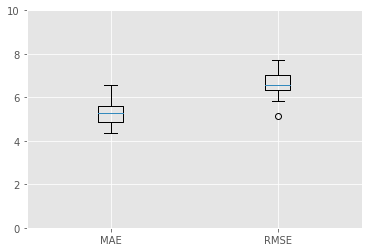

In [10]:
# Boxplots
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

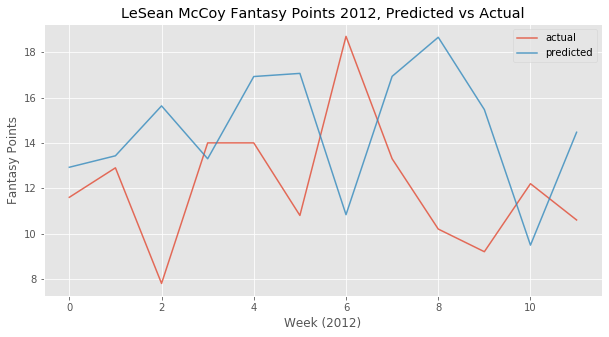

In [11]:
# Predicted versus actual
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.ylim((6, 32))
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')